In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

root = './round-4-island-data-bottle'

In [2]:
def allocate_cols(inp):
    return inp.split(';')

def get_data(filename):
    df = pd.read_csv(root + '/' + filename)
    cols = df.columns[0].split(';')
    df[df.columns[0]] = df[df.columns[0]].apply(allocate_cols)
    df = df[df.columns[0]].tolist()
    df = pd.DataFrame(df, columns=cols)
    coconut = df[df['product'] == 'COCONUT'].reset_index(drop=True).drop(columns=['product']).replace('', '0').astype(float)
    coupons = df[df['product'] == 'COCONUT_COUPON'].reset_index(drop=True).drop(columns=['product']).replace('', '0').astype(float)
    
    return {'COCONUT': coconut, 'COCONUT_COUPON': coupons}

In [3]:
fs = ['prices_round_4_day_' + str(i) + '.csv' for i in range(1, 4)]
fs

['prices_round_4_day_1.csv',
 'prices_round_4_day_2.csv',
 'prices_round_4_day_3.csv']

In [4]:
d = {}

for f in fs:
    d[int(f.split('_')[-1][0])] = get_data(f)

In [5]:
d[1]['COCONUT']

,day,timestamp,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1.0,0.0,9999.0,200.0,0.0,0.0,0.0,0.0,10001.0,200.0,0.0,0.0,0.0,0.0,10000.0,0.0
1,1.0,100.0,9999.0,104.0,9998.0,44.0,0.0,0.0,10000.0,104.0,10001.0,44.0,0.0,0.0,9999.5,0.0
2,1.0,200.0,9998.0,133.0,9997.0,62.0,0.0,0.0,9999.0,133.0,10000.0,62.0,0.0,0.0,9998.5,0.0
3,1.0,300.0,9999.0,149.0,9998.0,51.0,0.0,0.0,10000.0,149.0,10001.0,51.0,0.0,0.0,9999.5,0.0
4,1.0,400.0,9998.0,108.0,9997.0,63.0,0.0,0.0,9999.0,103.0,10000.0,63.0,0.0,0.0,9998.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,999500.0,10135.0,103.0,10134.0,51.0,0.0,0.0,10136.0,111.0,10137.0,51.0,0.0,0.0,10135.5,0.0
9996,1.0,999600.0,10136.0,130.0,10135.0,67.0,0.0,0.0,10137.0,130.0,10138.0,67.0,0.0,0.0,10136.5,0.0
9997,1.0,999700.0,10134.0,108.0,10133.0,54.0,0.0,0.0,10135.0,108.0,10136.0,54.0,0.0,0.0,10134.5,0.0
9998,1.0,999800.0,10134.0,122.0,10133.0,65.0,0.0,0.0,10136.0,181.0,0.0,0.0,0.0,0.0,10135.0,0.0


In [6]:
# Price regression

coconut_midprc = pd.concat([d[i]['COCONUT'] for i in range(1, 4)], axis=0).reset_index(drop=True)['mid_price']
coupon_midprc = pd.concat([d[i]['COCONUT_COUPON'] for i in range(1, 4)], axis=0).reset_index(drop=True)['mid_price']

X = sm.add_constant(coconut_midprc)
price_model = sm.OLS(coupon_midprc, X)
price_model_results = price_model.fit()

price_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mid_price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 3.337e+05
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:06:14   Log-Likelihood:            -1.2038e+05
No. Observations:               30000   AIC:                         2.408e+05
Df Residuals:                   29998   BIC:                         2.408e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4393.5047      8.706   -504.676      0.000   -4410.568   -4376.441
mid_price      0.5029      0.001    577.646      0.000       0.501       0.505
==============================================================================
Omnibus:                      125.636   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.563
Skew:                           0.088   Prob(JB):                     7.25e-24
Kurtosis:                       2.767   Cond. No.                     1.13e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
coconut_midret = pd.concat([d[i]['COCONUT']['mid_price'].pct_change().dropna() for i in range(1, 4)], axis=0).reset_index(drop=True)
coupon_midret = pd.concat([d[i]['COCONUT_COUPON']['mid_price'].pct_change().dropna() for i in range(1, 4)], axis=0).reset_index(drop=True)

XX = sm.add_constant(coconut_midret)
returns_model = sm.OLS(coupon_midret, XX)
returns_model_results = returns_model.fit()

returns_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mid_price   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     7056.
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:41:58   Log-Likelihood:             1.4900e+05
No. Observations:               29997   AIC:                        -2.980e+05
Df Residuals:                   29995   BIC:                        -2.980e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.495e-06   9.73e-06      0.154      0.878   -1.76e-05    2.06e-05
mid_price      7.9391      0.095     83.998      0.000       7.754       8.124
==============================================================================
Omnibus:                        3.437   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.420
Skew:                           0.026   Prob(JB):                        0.181
Kurtosis:                       3.012   Cond. No.                     9.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

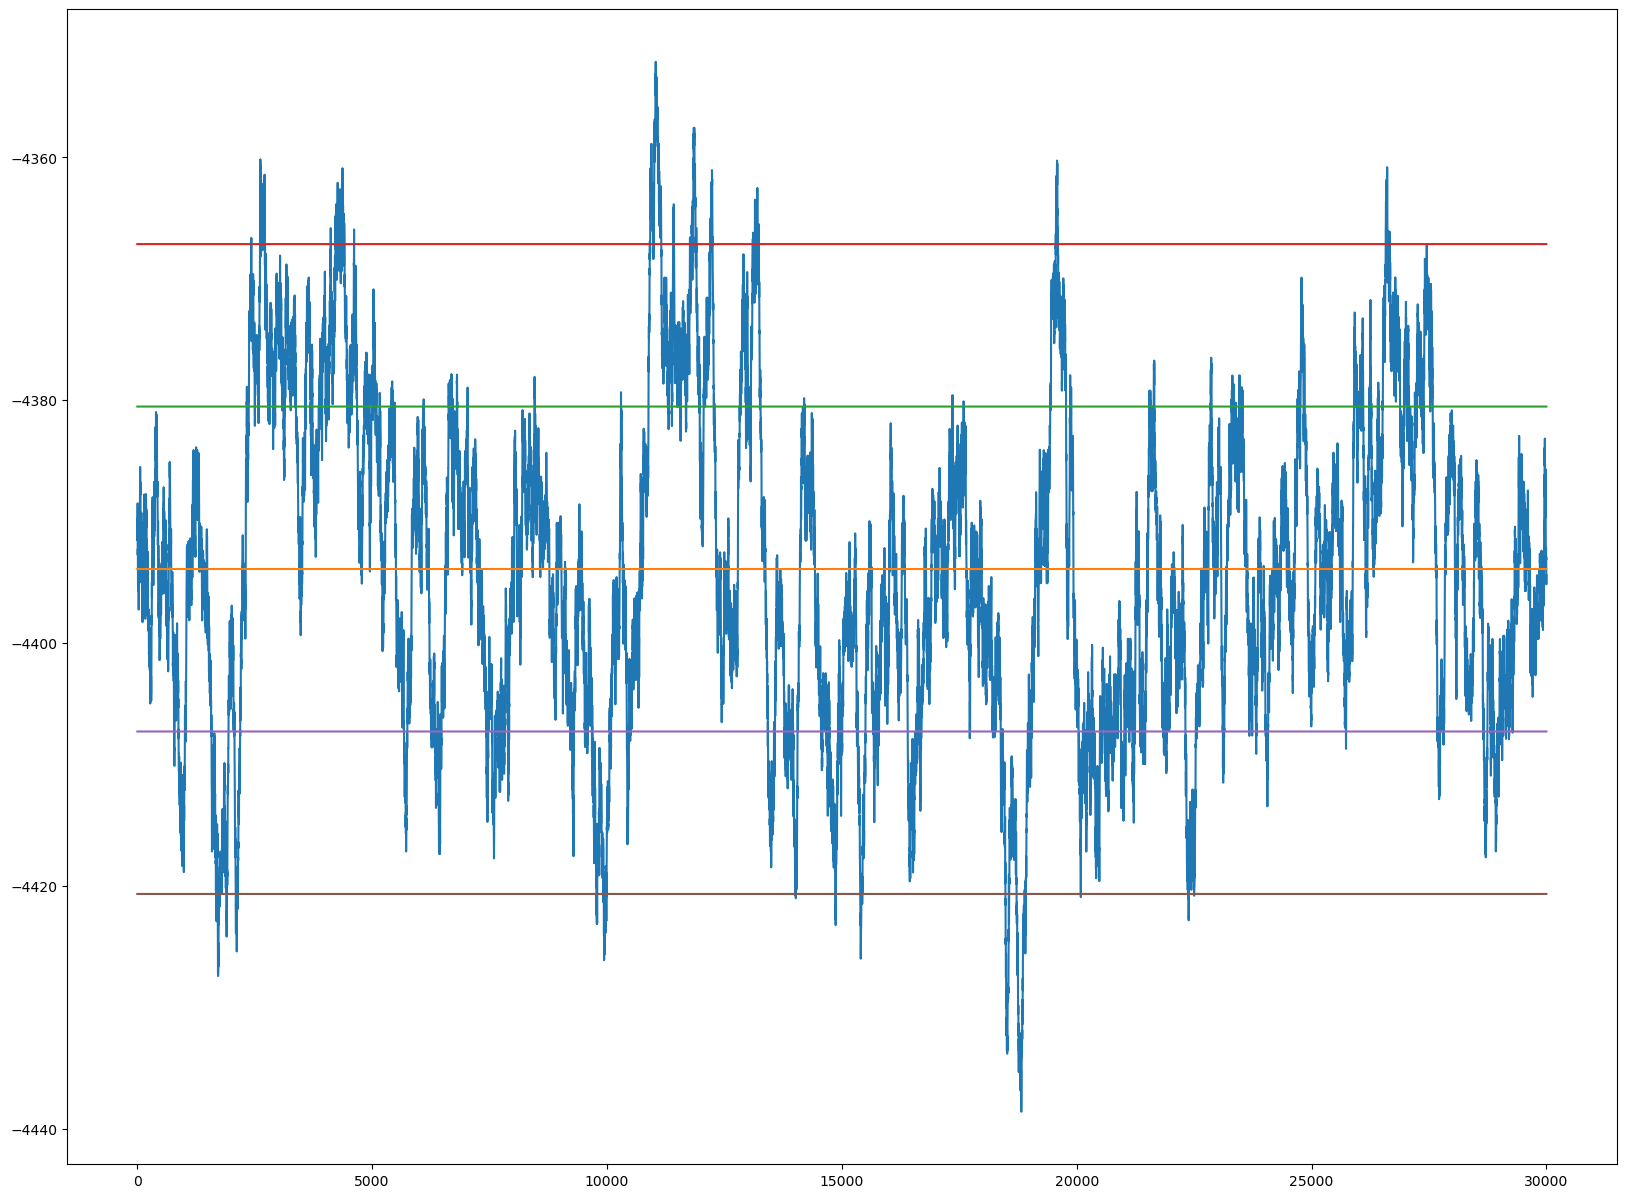

In [16]:
plt.figure(figsize=(20,15))
spread = coupon_midprc - 0.5029*coconut_midprc
plt.plot(spread)
plt.plot([spread.mean()]*len(spread))
plt.plot([spread.mean() + spread.std()]*len(spread))
plt.plot([spread.mean() + 2*spread.std()]*len(spread))
plt.plot([spread.mean() - spread.std()]*len(spread))
plt.plot([spread.mean() - 2*spread.std()]*len(spread))

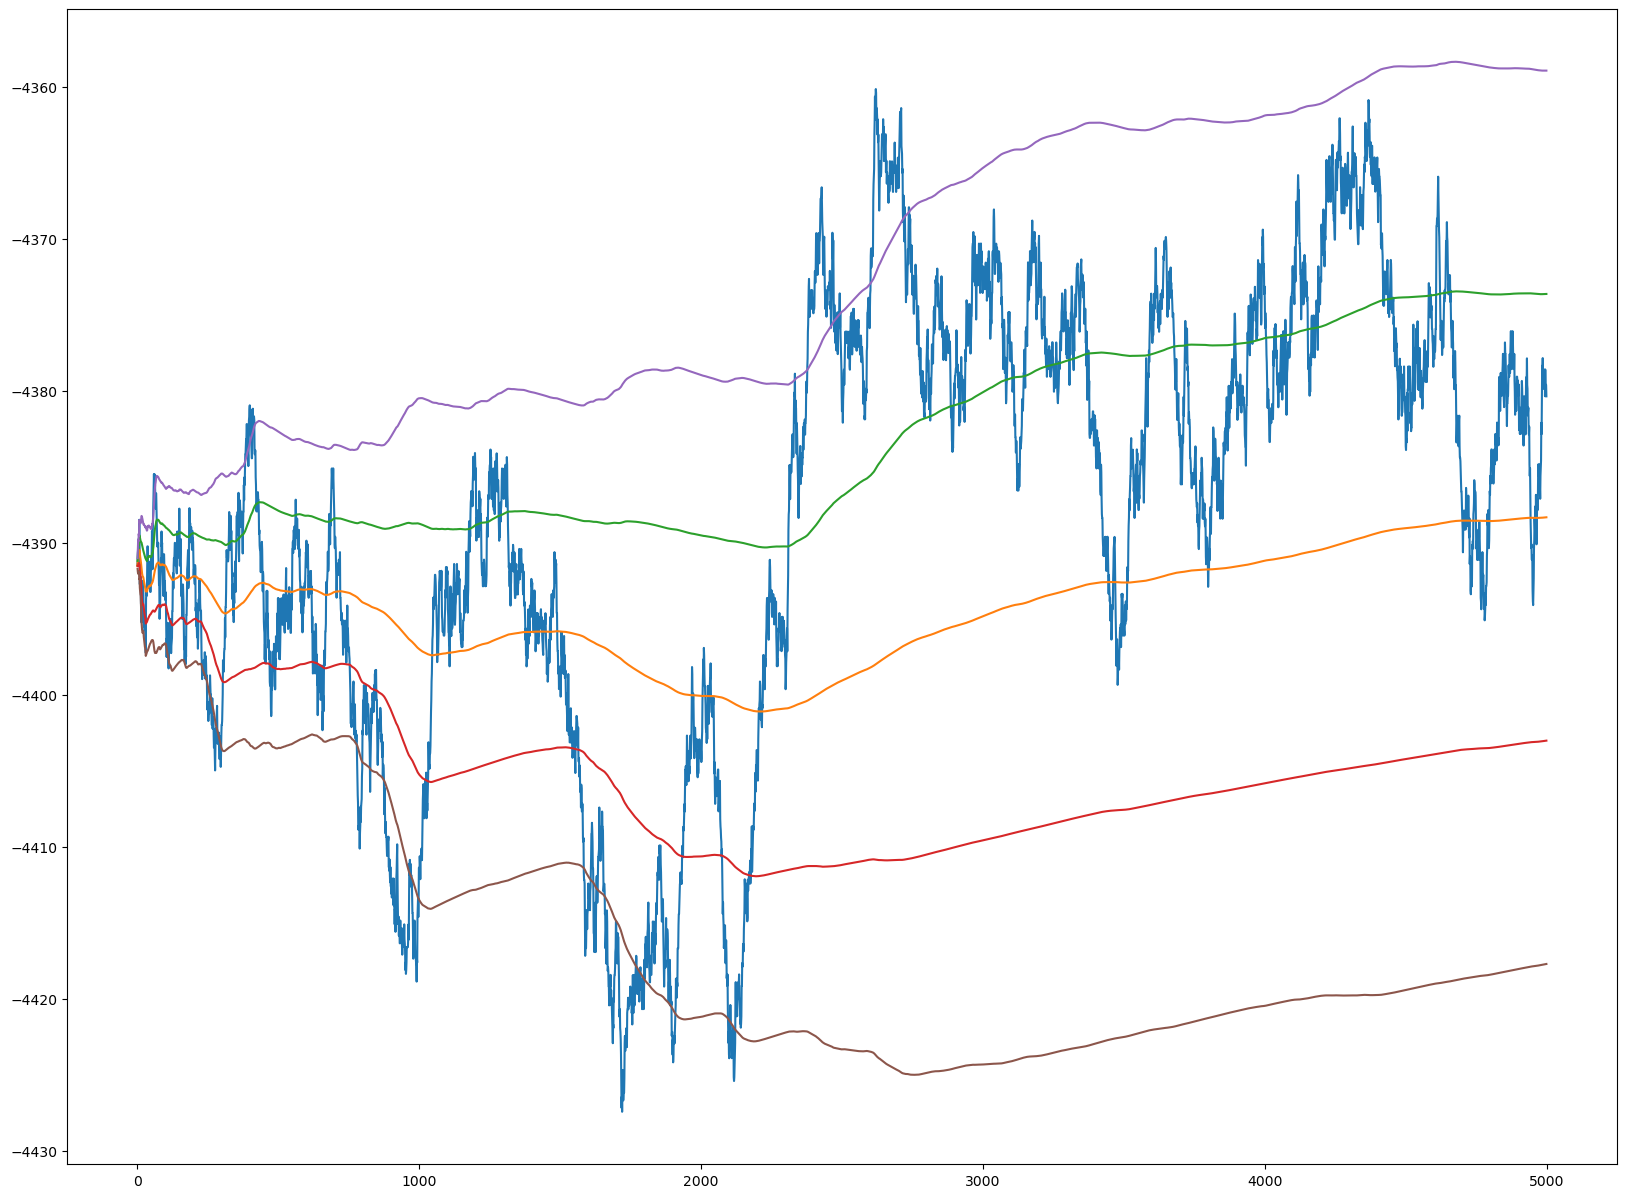

In [19]:
plt.figure(figsize=(20,15))
cmean = spread.expanding().mean()
cstd = spread.expanding().std()
plt.plot(spread.iloc[:5000])
plt.plot(cmean.iloc[:5000])
plt.plot((cmean + cstd).iloc[:5000])
plt.plot((cmean - cstd).iloc[:5000])
plt.plot((cmean + 2*cstd).iloc[:5000])
plt.plot((cmean - 2*cstd).iloc[:5000])

(array([ 121.,  315., 1828., 4696., 7365., 6824., 4743., 3030.,  952.,
         126.]),
 array([-4438.6102  , -4429.961445, -4421.31269 , -4412.663935,
        -4404.01518 , -4395.366425, -4386.71767 , -4378.068915,
        -4369.42016 , -4360.771405, -4352.12265 ]),
 <BarContainer object of 10 artists>)

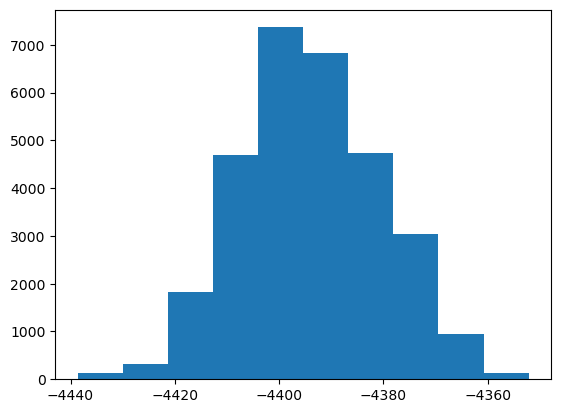

In [17]:
plt.hist(spread)

In [19]:
# On test data
df = pd.read_csv('./test_data.csv')
cols = df.columns[0].split(';')
df[df.columns[0]] = df[df.columns[0]].apply(allocate_cols)
df = df[df.columns[0]].tolist()
df = pd.DataFrame(df, columns=cols)
coconut = df[df['product'] == 'COCONUT'].reset_index(drop=True).drop(columns=['product']).replace('', '0').astype(float)
coupons = df[df['product'] == 'COCONUT_COUPON'].reset_index(drop=True).drop(columns=['product']).replace('', '0').astype(float)
coconut

,day,timestamp,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,3.0,0.0,9990.0,136.0,9989.0,49.0,0.0,0.0,9992.0,185.0,0.0,0.0,0.0,0.0,9991.0,0.0
1,3.0,100.0,9989.0,143.0,0.0,0.0,0.0,0.0,9991.0,101.0,9992.0,42.0,0.0,0.0,9990.0,0.0
2,3.0,200.0,9990.0,99.0,9989.0,67.0,0.0,0.0,9991.0,105.0,9992.0,67.0,0.0,0.0,9990.5,0.0
3,3.0,300.0,9991.0,114.0,9990.0,42.0,0.0,0.0,9992.0,114.0,9993.0,42.0,0.0,0.0,9991.5,0.0
4,3.0,400.0,9989.0,129.0,9988.0,71.0,0.0,0.0,9991.0,200.0,0.0,0.0,0.0,0.0,9990.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.0,99500.0,9960.0,172.0,0.0,0.0,0.0,0.0,9962.0,128.0,9963.0,44.0,0.0,0.0,9961.0,0.0
996,3.0,99600.0,9960.0,135.0,9959.0,63.0,0.0,0.0,9961.0,135.0,9962.0,63.0,0.0,0.0,9960.5,0.0
997,3.0,99700.0,9962.0,146.0,9961.0,56.0,0.0,0.0,9963.0,146.0,9964.0,56.0,0.0,0.0,9962.5,0.0
998,3.0,99800.0,9963.0,120.0,9962.0,49.0,0.0,0.0,9964.0,110.0,9965.0,49.0,0.0,0.0,9963.5,0.0


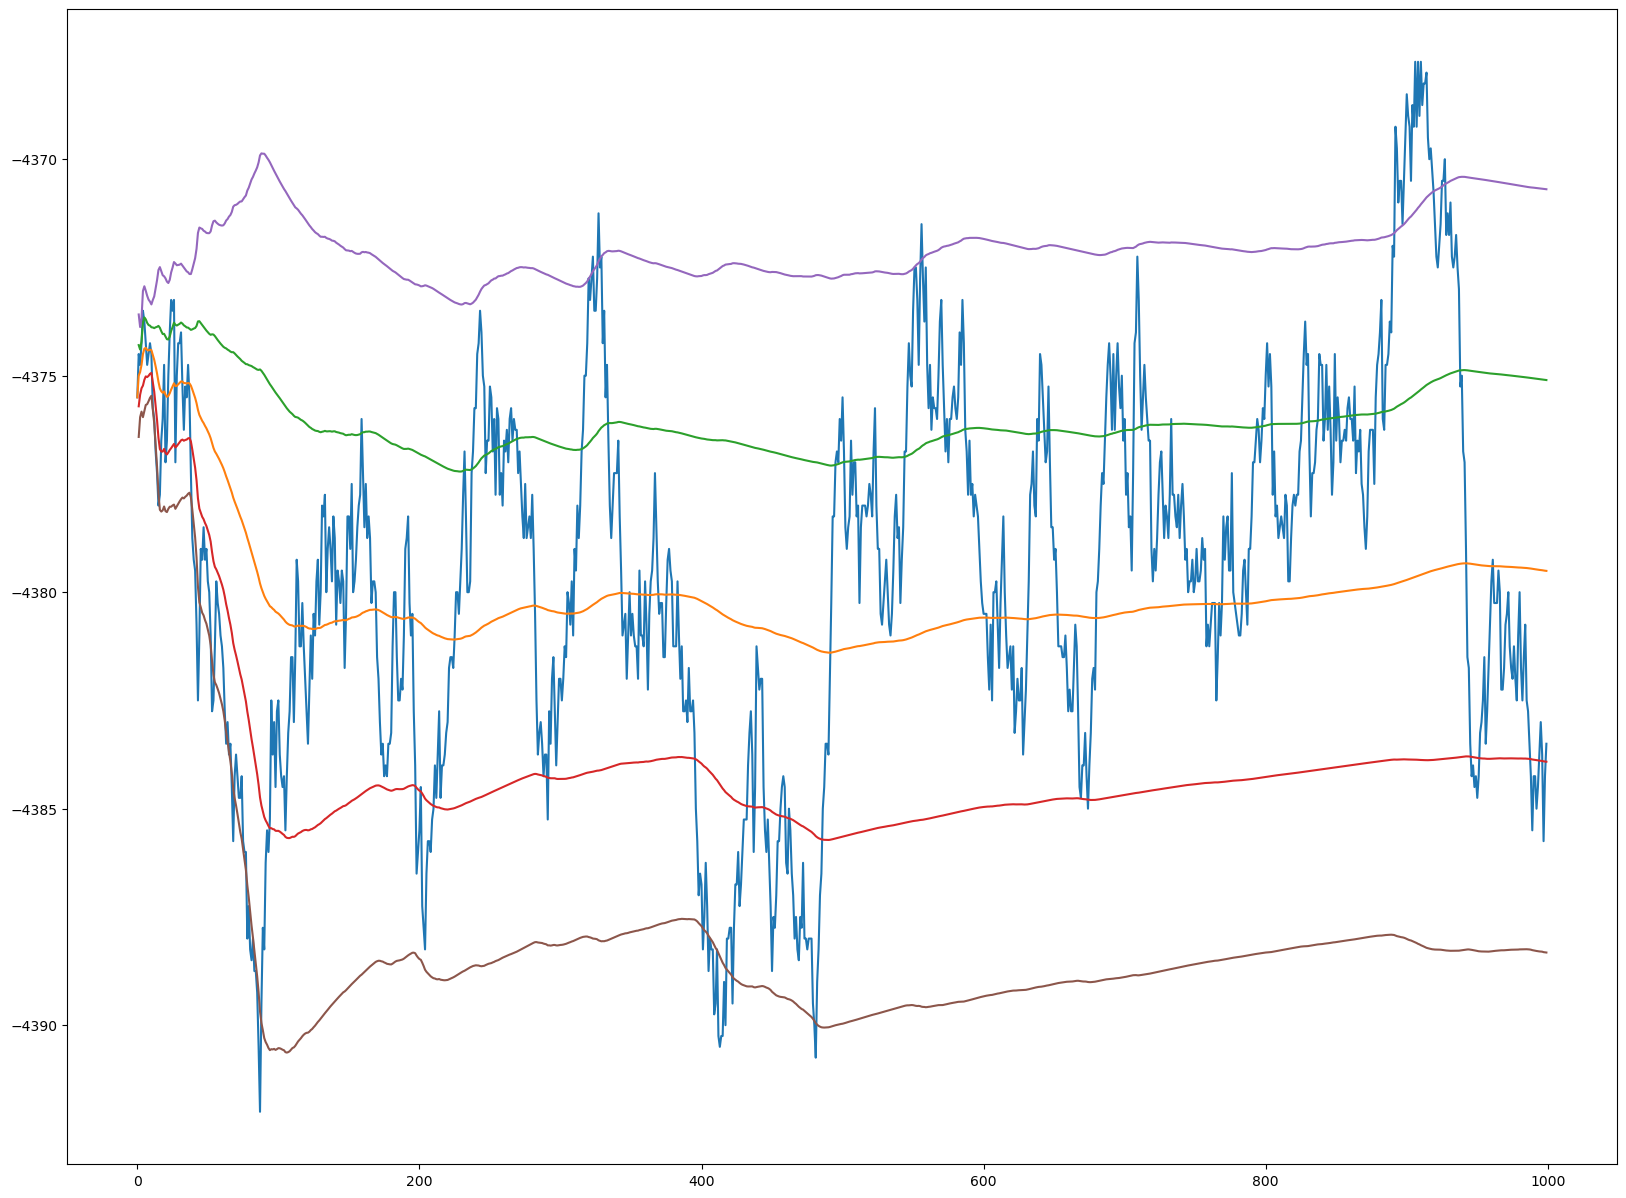

In [20]:
testspread = coupons['mid_price'] - 0.5*coconut['mid_price']
plt.figure(figsize=(20,15))
ctestmean = testspread.expanding().mean()
cteststd = testspread.expanding().std()
plt.plot(testspread)
plt.plot(ctestmean)
plt.plot((ctestmean + cteststd))
plt.plot((ctestmean - cteststd))
plt.plot((ctestmean + 2*cteststd))
plt.plot((ctestmean - 2*cteststd))

In [21]:
coconut_midprc = pd.concat([d[i]['COCONUT'] for i in range(1, 4)], axis=0).reset_index(drop=True)['mid_price']
coupon_midprc = pd.concat([d[i]['COCONUT_COUPON'] for i in range(1, 4)], axis=0).reset_index(drop=True)['mid_price']

X = sm.add_constant(coupon_midprc)
price_model = sm.OLS(coconut_midprc, X)
price_model_results = price_model.fit()

price_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mid_price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 3.337e+05
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:44:46   Log-Likelihood:            -1.3972e+05
No. Observations:               30000   AIC:                         2.794e+05
Df Residuals:                   29998   BIC:                         2.795e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8841.2014      2.011   4395.781      0.000    8837.259    8845.144
mid_price      1.8246      0.003    577.646      0.000       1.818       1.831
==============================================================================
Omnibus:                      217.434   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.234
Skew:                           0.051   Prob(JB):                     5.32e-34
Kurtosis:                       2.665   Cond. No.                     8.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

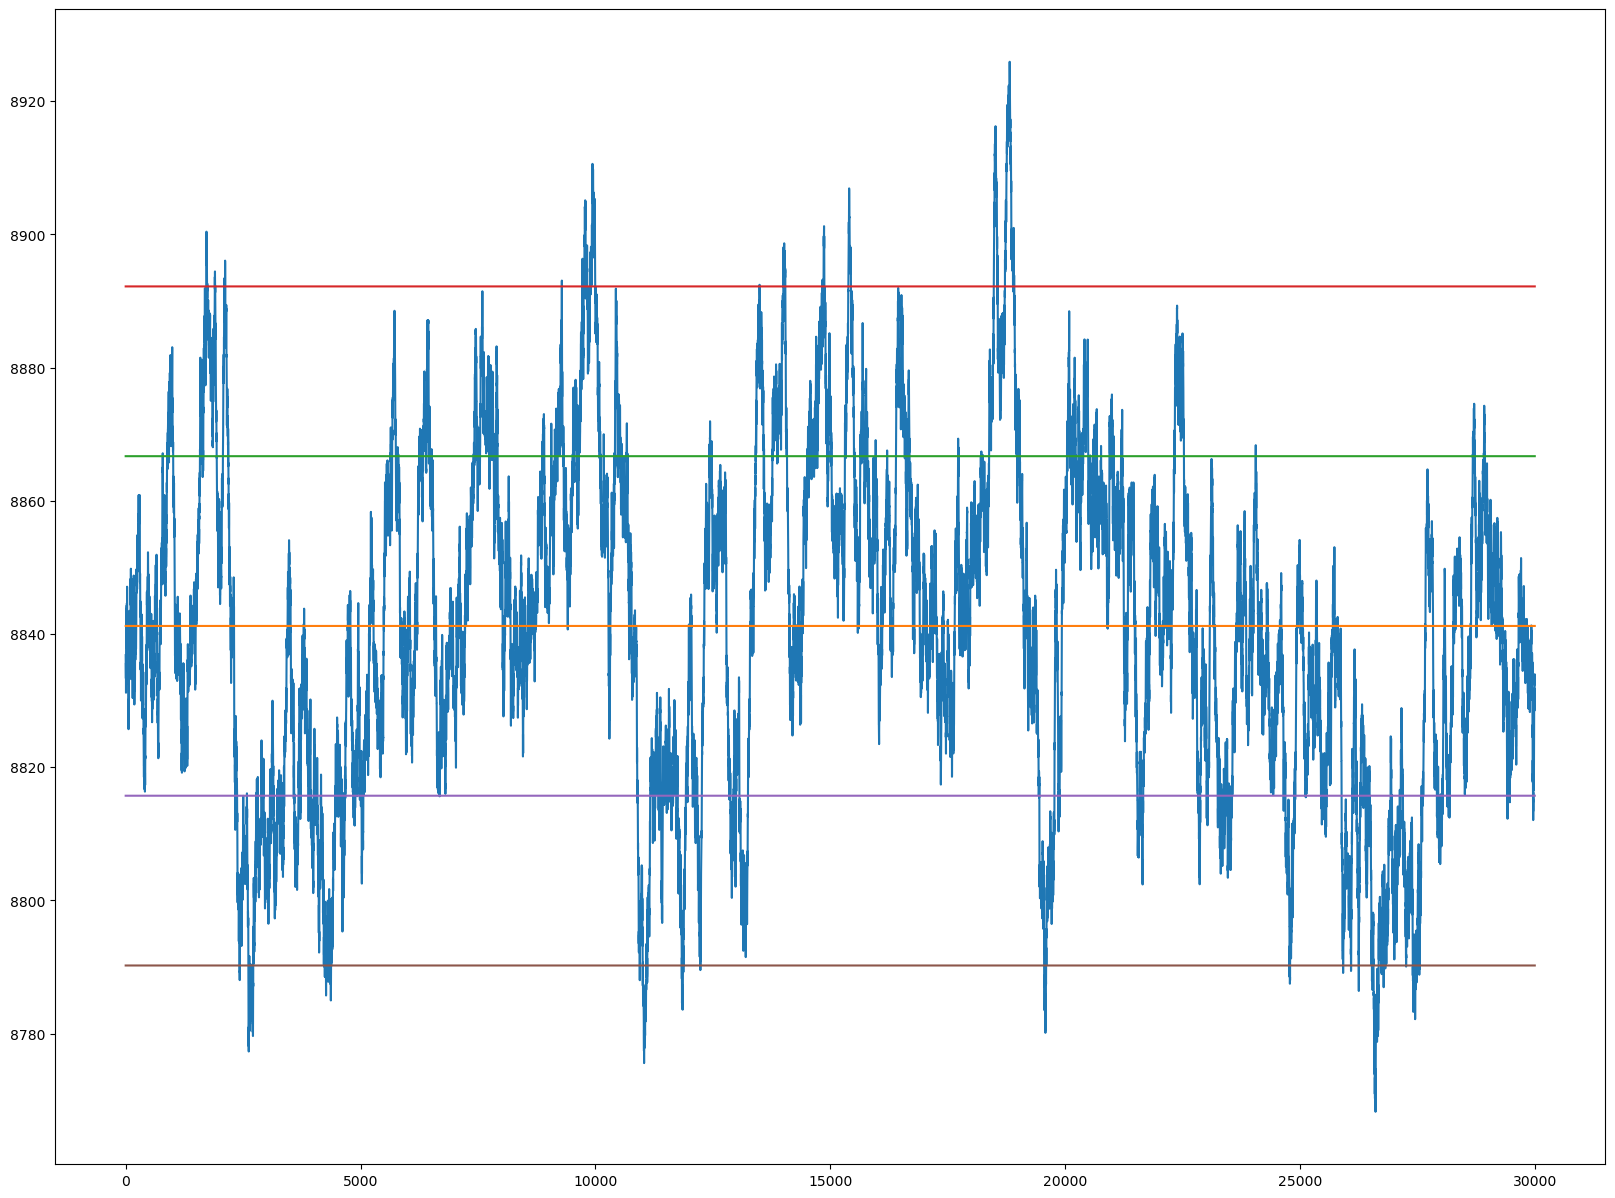

In [22]:
plt.figure(figsize=(20,15))
spread = coconut_midprc - 1.8246*coupon_midprc
plt.plot(spread)
plt.plot([spread.mean()]*len(spread))
plt.plot([spread.mean() + spread.std()]*len(spread))
plt.plot([spread.mean() + 2*spread.std()]*len(spread))
plt.plot([spread.mean() - spread.std()]*len(spread))
plt.plot([spread.mean() - 2*spread.std()]*len(spread))

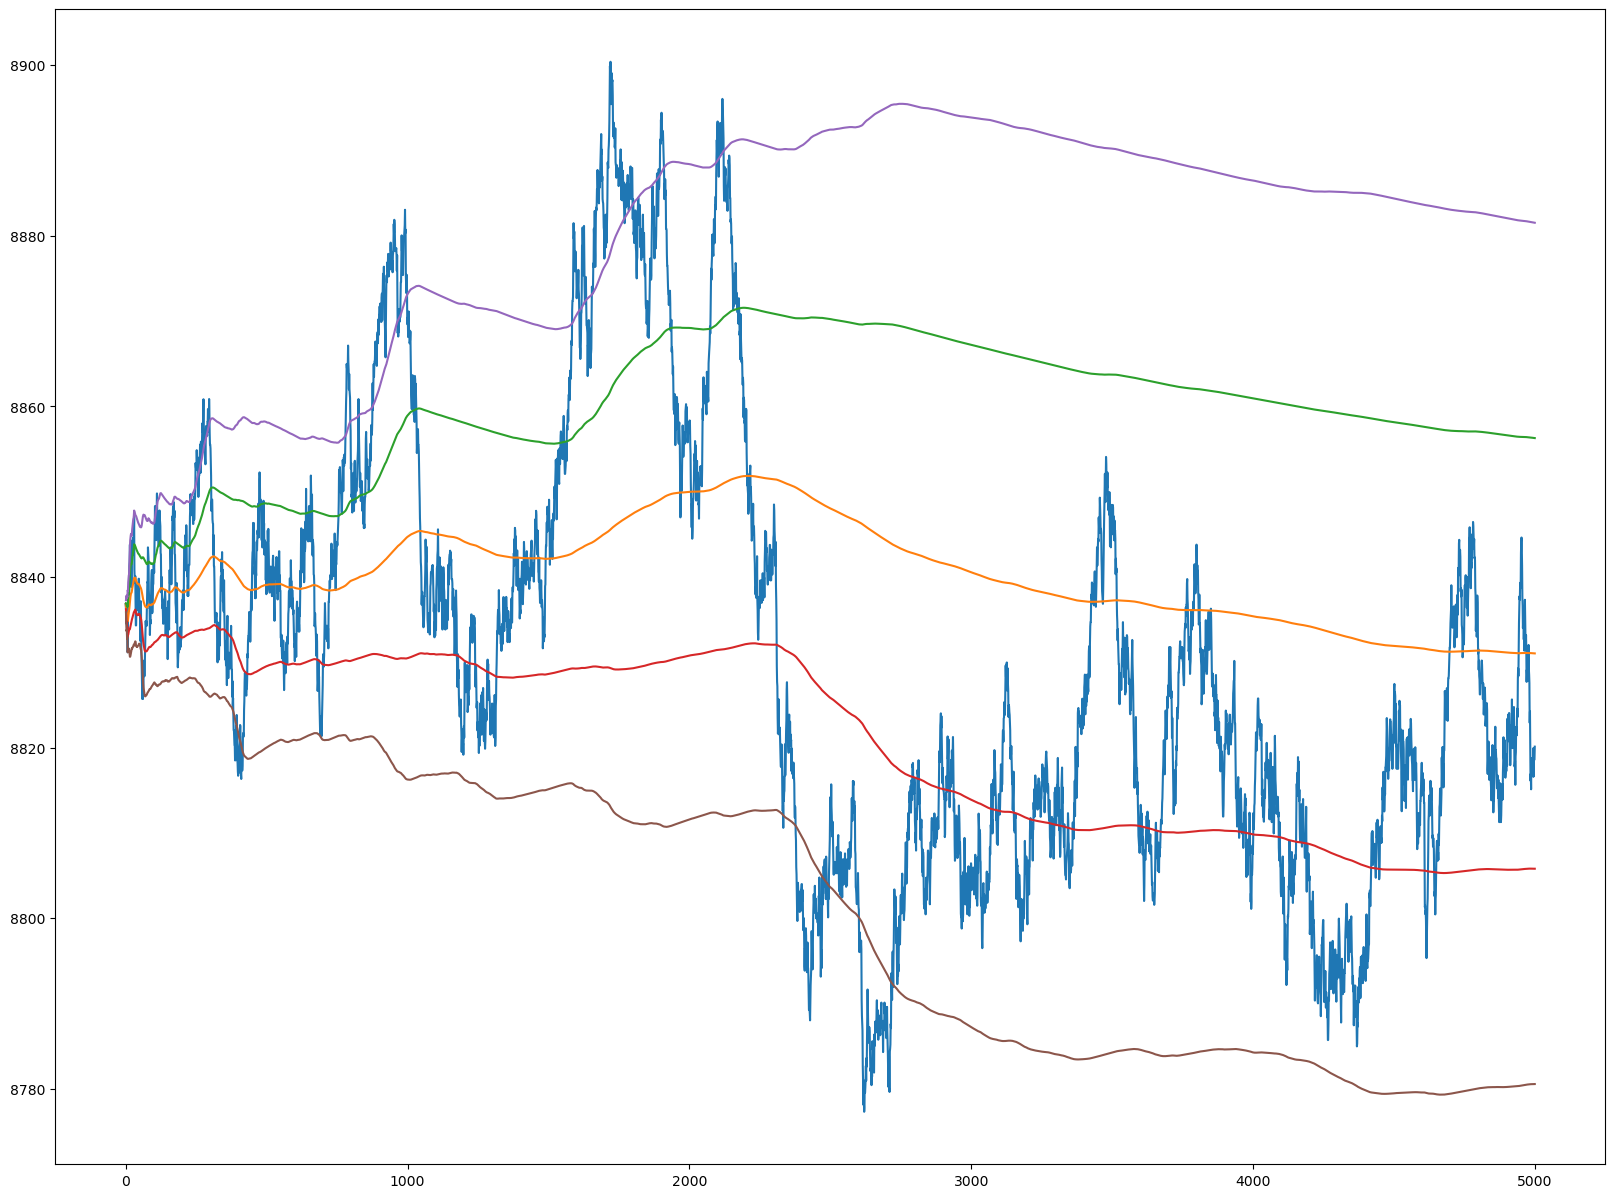

In [23]:
plt.figure(figsize=(20,15))
cmean = spread.expanding().mean()
cstd = spread.expanding().std()
plt.plot(spread.iloc[:5000])
plt.plot(cmean.iloc[:5000])
plt.plot((cmean + cstd).iloc[:5000])
plt.plot((cmean - cstd).iloc[:5000])
plt.plot((cmean + 2*cstd).iloc[:5000])
plt.plot((cmean - 2*cstd).iloc[:5000])

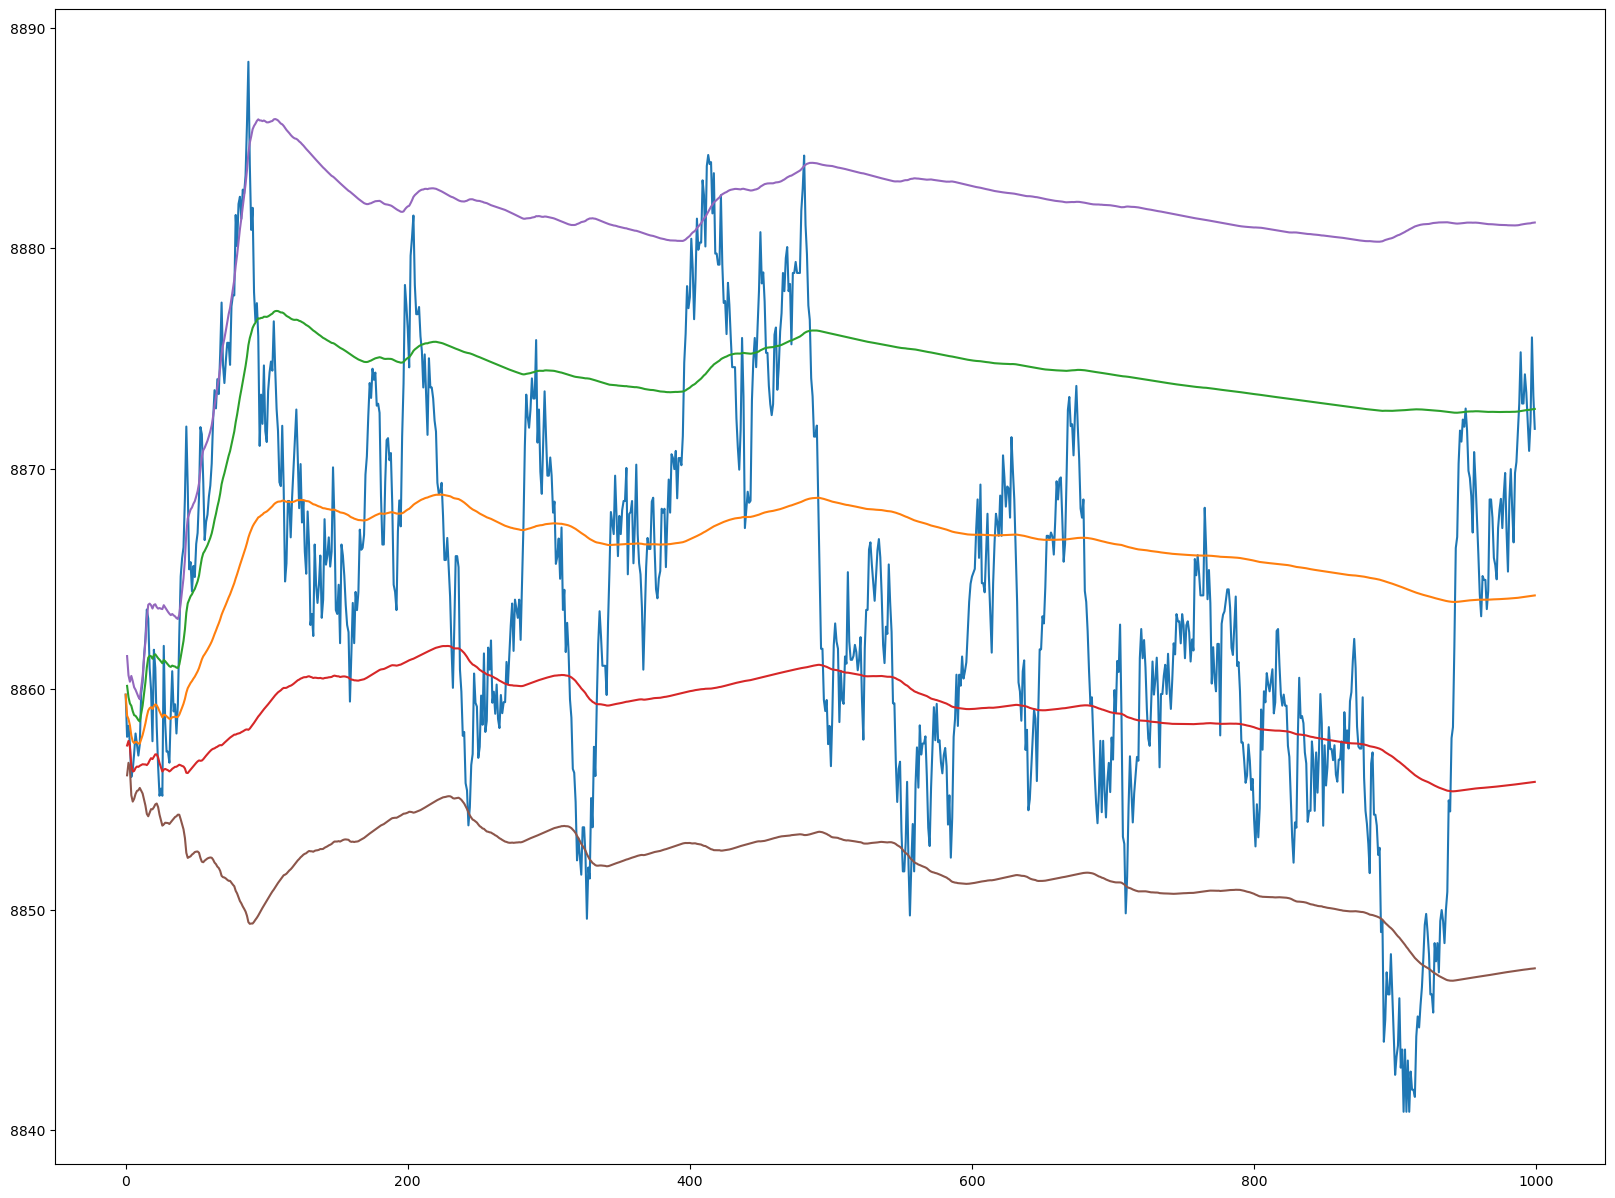

In [24]:
testspread = coconut['mid_price'] - 1.8246*coupons['mid_price']
plt.figure(figsize=(20,15))
ctestmean = testspread.expanding().mean()
cteststd = testspread.expanding().std()
plt.plot(testspread)
plt.plot(ctestmean)
plt.plot((ctestmean + cteststd))
plt.plot((ctestmean - cteststd))
plt.plot((ctestmean + 2*cteststd))
plt.plot((ctestmean - 2*cteststd))

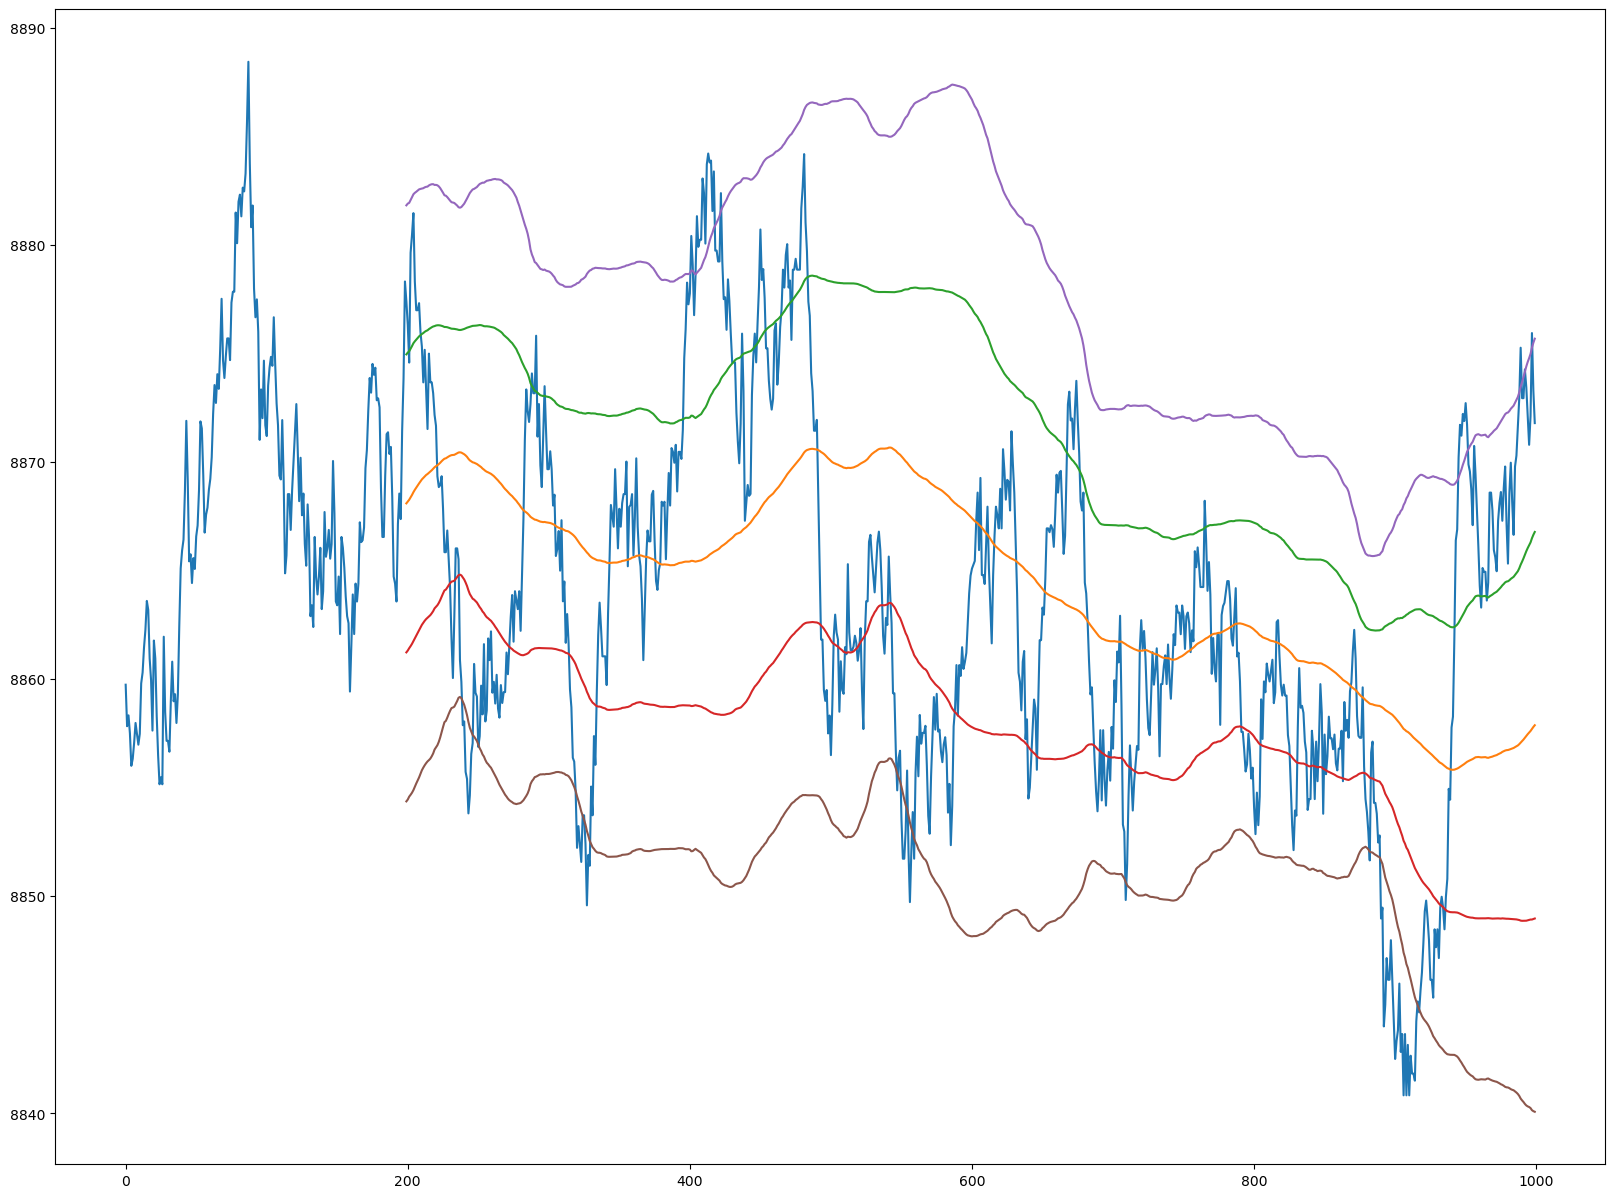

In [25]:
plt.figure(figsize=(20,15))
ctestmean = testspread.rolling(window=200).mean()
cteststd = testspread.rolling(window=200).std()
plt.plot(testspread)
plt.plot(ctestmean)
plt.plot((ctestmean + cteststd))
plt.plot((ctestmean - cteststd))
plt.plot((ctestmean + 2*cteststd))
plt.plot((ctestmean - 2*cteststd))

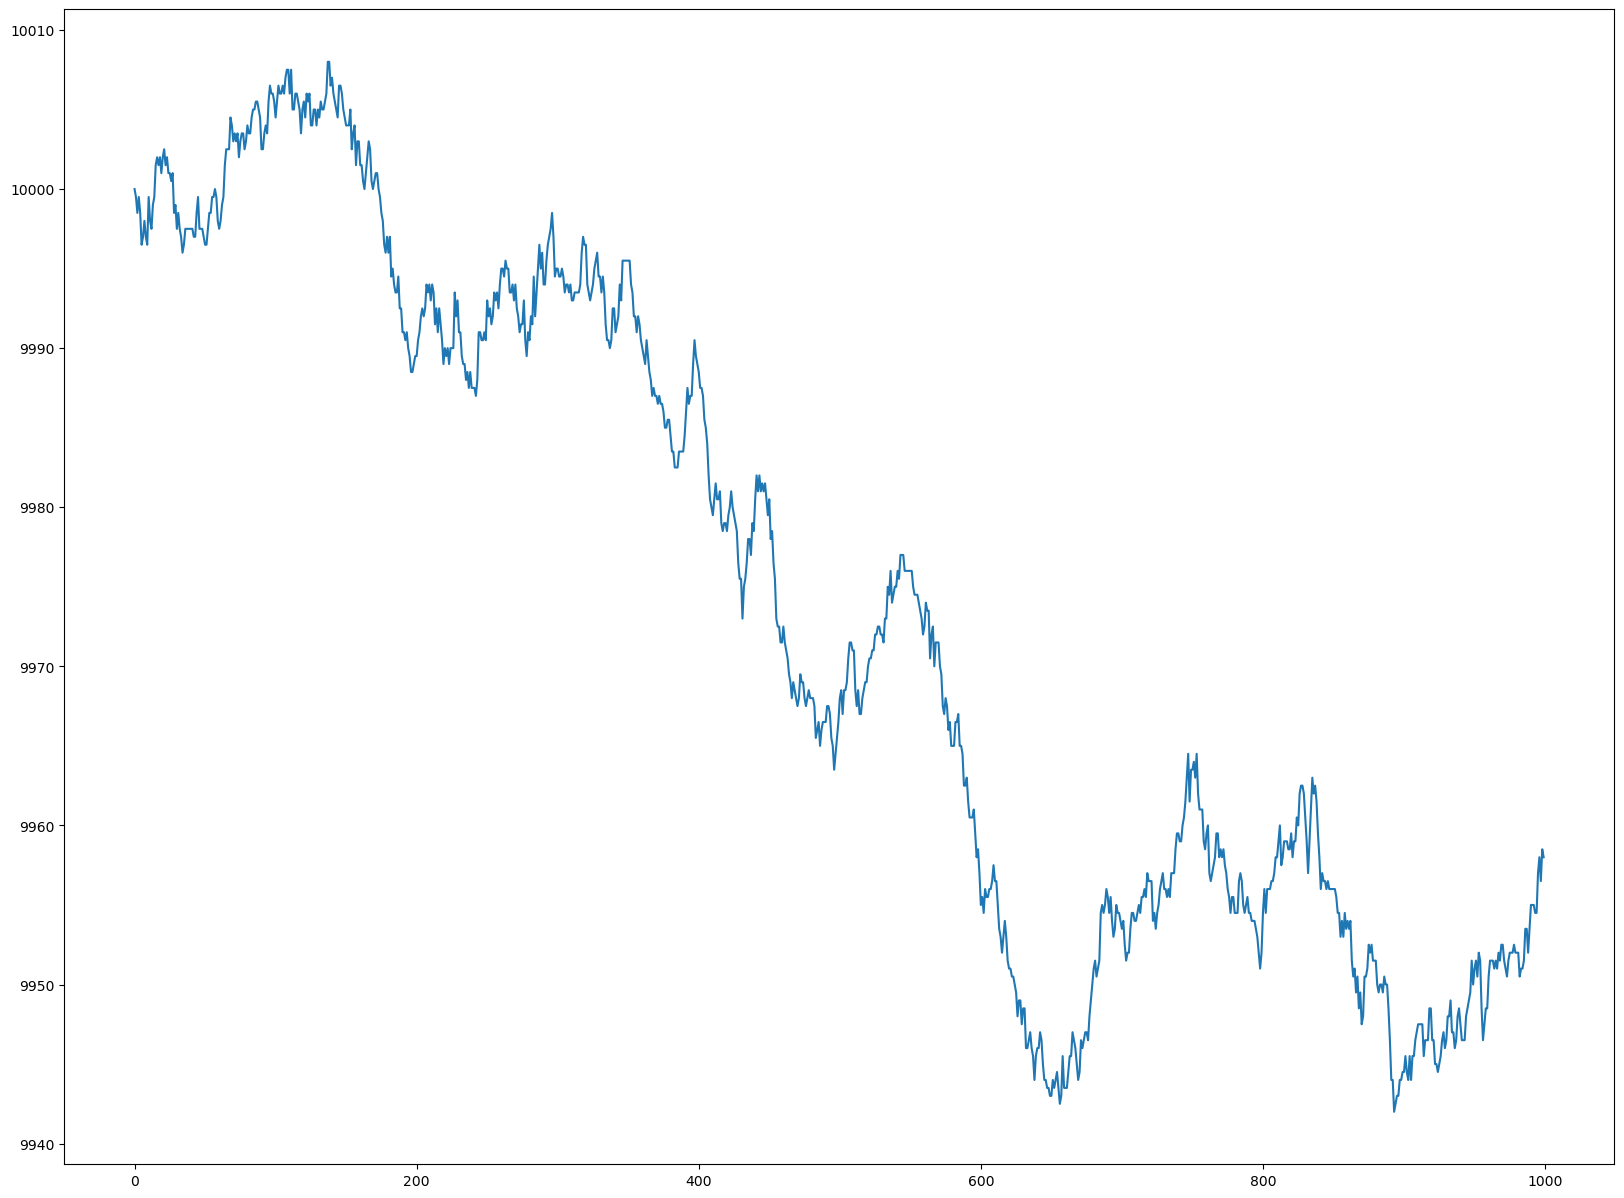

In [26]:
plt.figure(figsize=(20,15))
plt.plot(coconut_midprc.iloc[:1000])

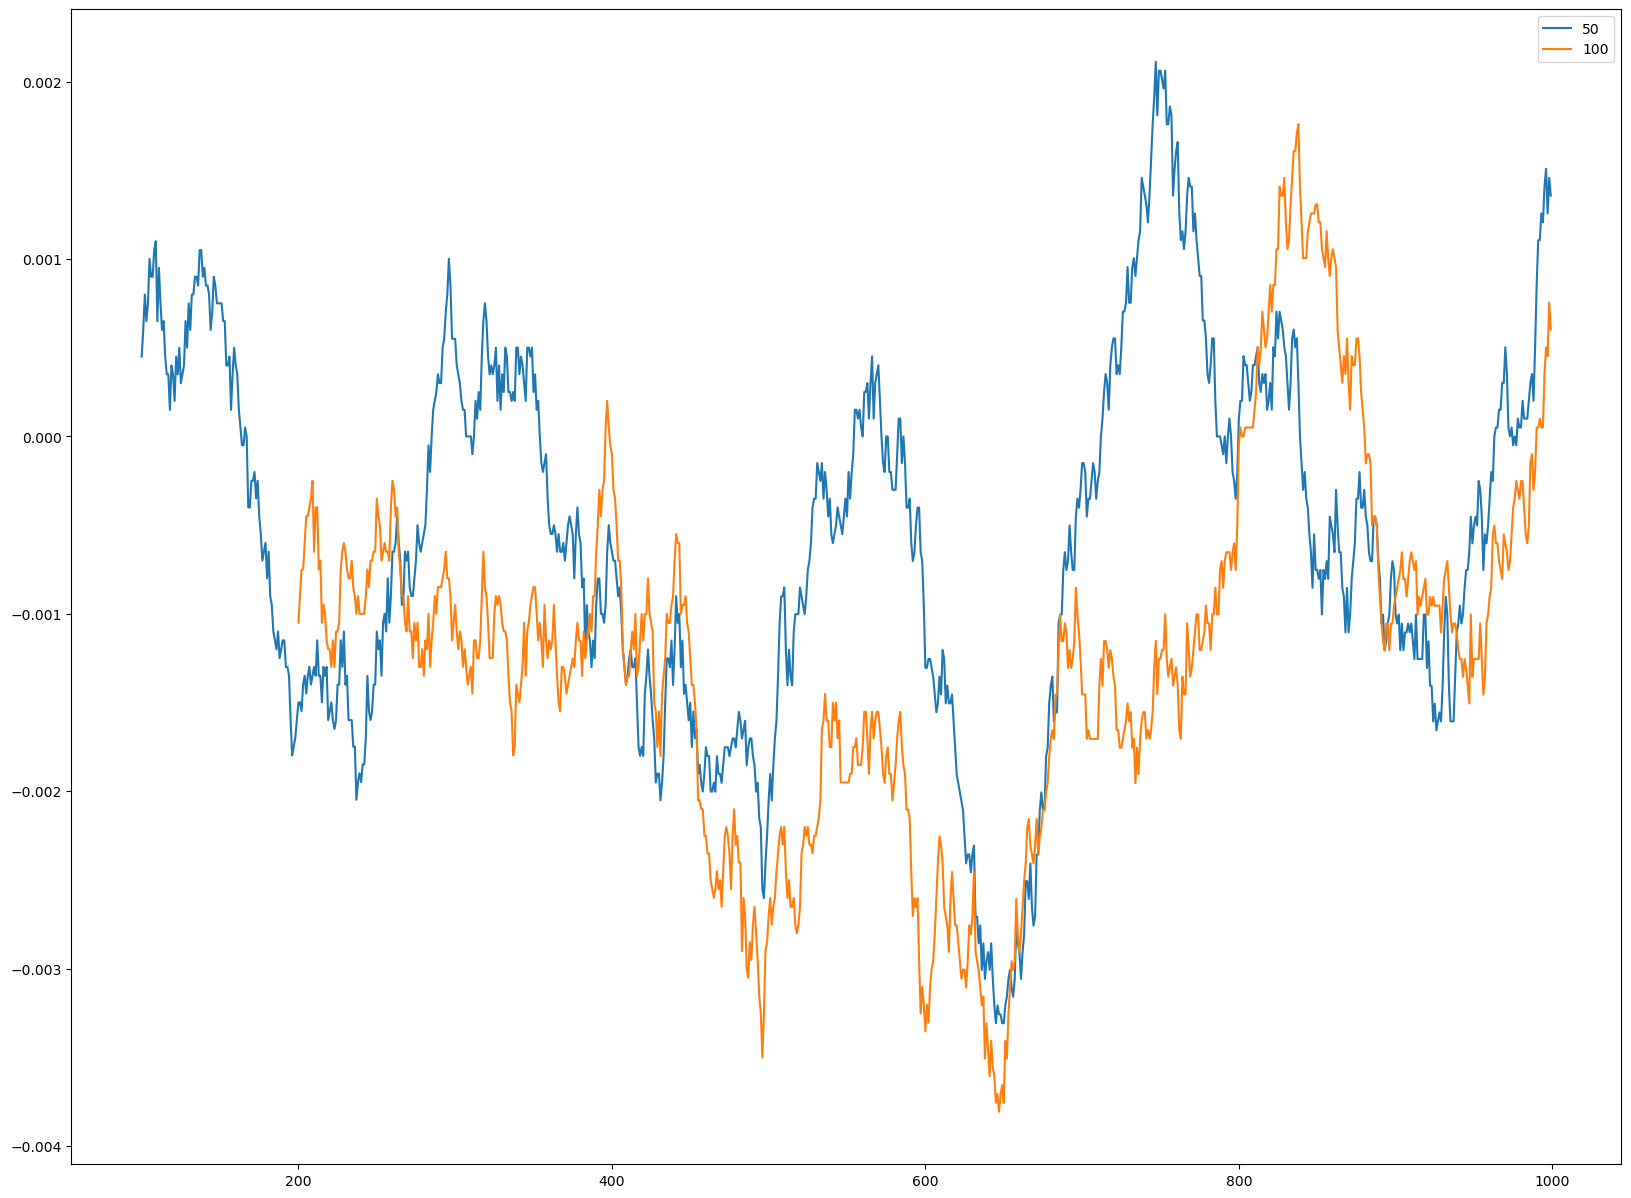

In [17]:
cm1 = coconut_midprc.pct_change(100)
cm2 = coconut_midprc.pct_change(200)

plt.figure(figsize=(20, 15))
plt.plot(cm1.iloc[:1000], label='50')
plt.plot(cm2.iloc[:1000], label='100')
plt.legend()

In [12]:
df = pd.read_csv('./test_data.csv')
cols = df.columns[0].split(';')
df[df.columns[0]] = df[df.columns[0]].apply(allocate_cols)
df = df[df.columns[0]].tolist()
df = pd.DataFrame(df, columns=cols)
straw = df[df['product'] == 'STRAWBERRIES'].reset_index(drop=True).drop(columns=['product']).replace('', '0').astype(float)
straw

,day,timestamp,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,3.0,0.0,3984.0,272.0,0.0,0.0,0.0,0.0,3986.0,272.0,0.0,0.0,0.0,0.0,3985.0,0.0000
1,3.0,100.0,3984.0,155.0,0.0,0.0,0.0,0.0,3986.0,155.0,0.0,0.0,0.0,0.0,3985.0,0.0000
2,3.0,200.0,3984.0,236.0,0.0,0.0,0.0,0.0,3986.0,236.0,0.0,0.0,0.0,0.0,3985.0,0.0000
3,3.0,300.0,3984.0,189.0,0.0,0.0,0.0,0.0,3985.0,80.0,3986.0,109.0,0.0,0.0,3984.5,0.0000
4,3.0,400.0,3984.0,207.0,0.0,0.0,0.0,0.0,3986.0,207.0,0.0,0.0,0.0,0.0,3985.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.0,99500.0,3966.0,83.0,3965.0,137.0,0.0,0.0,3967.0,220.0,0.0,0.0,0.0,0.0,3966.5,-3283.0000
996,3.0,99600.0,3965.0,187.0,0.0,0.0,0.0,0.0,3967.0,187.0,0.0,0.0,0.0,0.0,3966.0,-3315.5625
997,3.0,99700.0,3965.0,273.0,0.0,0.0,0.0,0.0,3967.0,273.0,0.0,0.0,0.0,0.0,3966.0,-3290.3125
998,3.0,99800.0,3965.0,205.0,0.0,0.0,0.0,0.0,3967.0,205.0,0.0,0.0,0.0,0.0,3966.0,-3315.2500


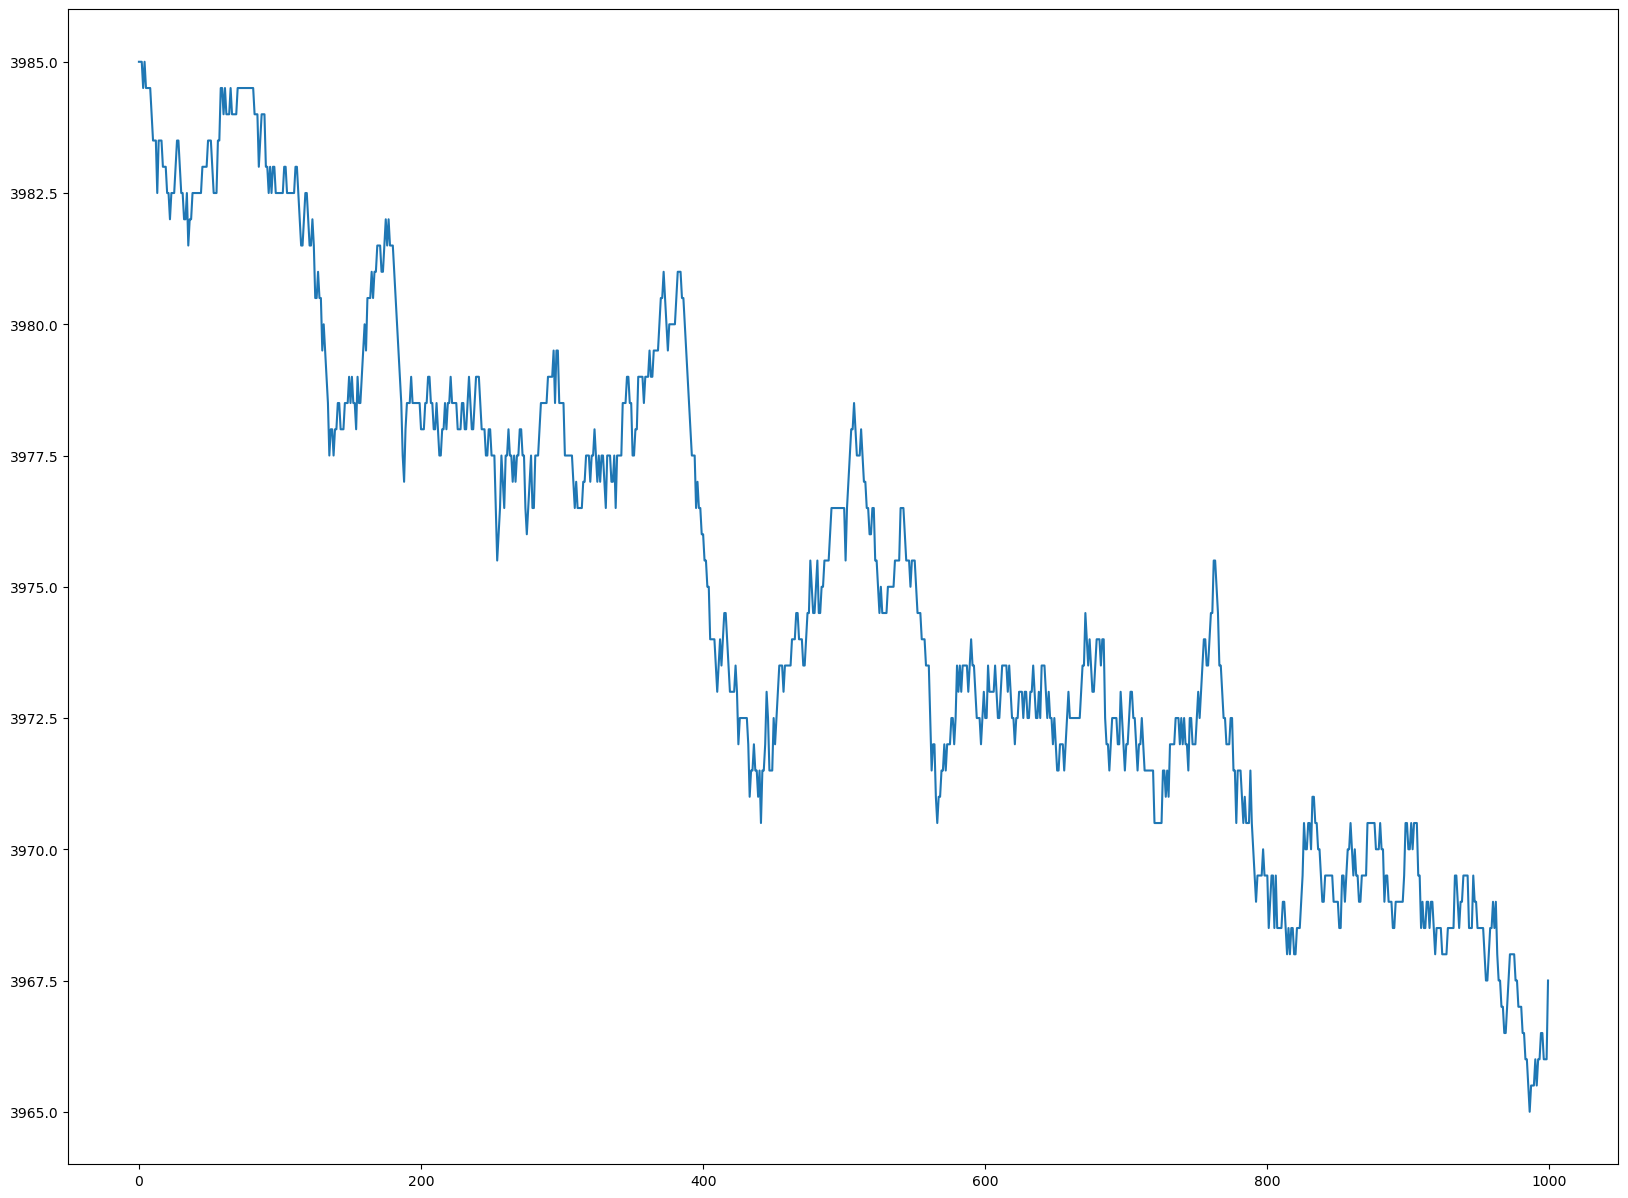

In [13]:
plt.figure(figsize=(20,15))
plt.plot(straw['mid_price'])

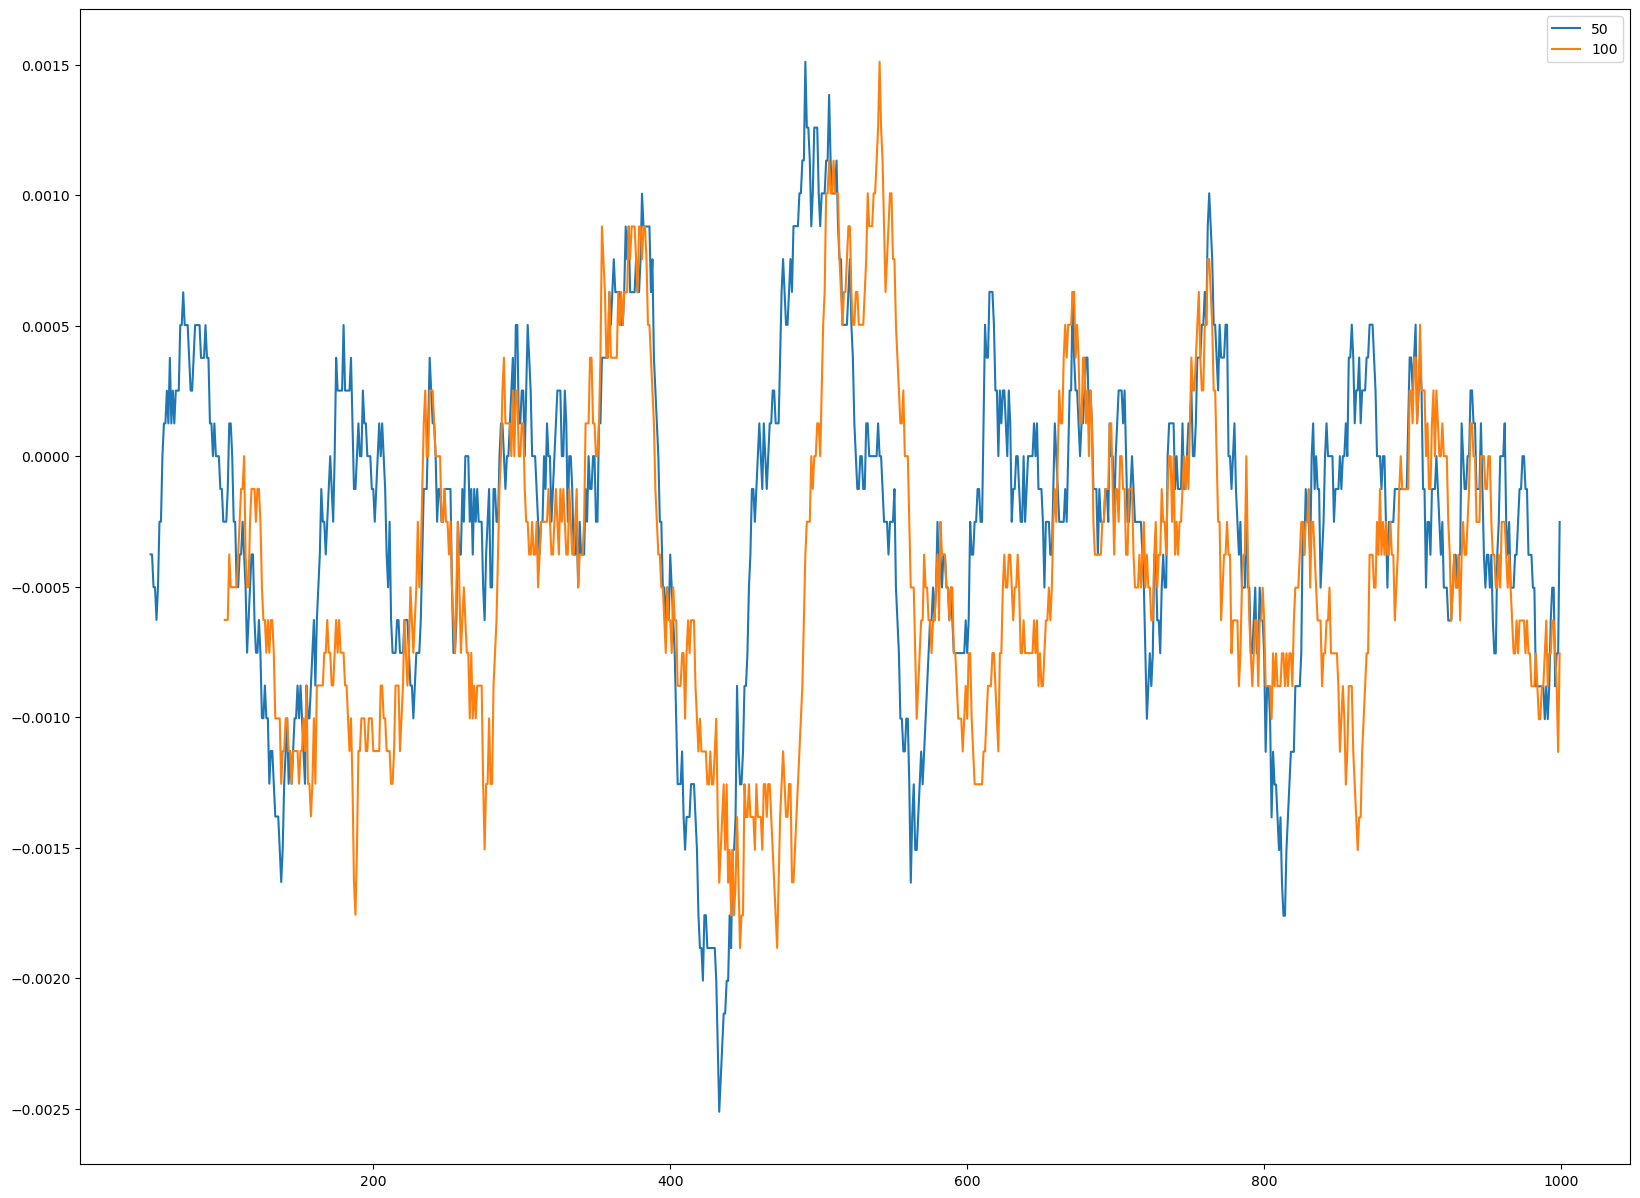

In [14]:
sw1 = straw['mid_price'].pct_change(50)
sw2 = straw['mid_price'].pct_change(100)

plt.figure(figsize=(20, 15))
plt.plot(sw1, label='50')
plt.plot(sw2, label='100')
plt.legend()